# This notebook contains preliminary results

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

from tabulate import tabulate # Have to dowload this on laptop
# print(tabulate(df_baselines_edited[(df_baselines_edited.Diagnosis == 1)].describe().round(3),tablefmt="grid", headers='keys'))
from pathlib import Path
from src.postprocess_cnn_results import PostprocessTalos, mean_std_auc
from src.preprocess_baseline import (calculate_iki_and_ed_baseline,
                                           calculate_all_baseline_ROC_curves,
                                           convert_df_to_subject_level,
                                           get_X_and_y_from_df,
                                           test_different_splits_for_classification)

from src.preprocess import iki_pause_correction

from src.plotting import (plot_roc_curve_simple,
                            nice_fonts,
                            plot_superimposed_roc_curves, 
                            plot_superimposed_roc_curves_with_confidence_bounds)
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import pickle
data_root = "/home/neil/cloud/habitual_errors_NLP/data/"
data_root = Path(data_root)

Using TensorFlow backend.


To do:

1. ~~Change the percentile calculation (use np.percentile()) and then use the fitted model for the replacement value~~
2. ~~Change Percenttile value for MJFF and MRC IKI replacements~~
3. ~~Run results for Spanish data as well (download the meta file as well)~~
    1. ~~Load raw~~
    2. ~~Clean with baseline methods~~
    3. ~~Filter and replace IKI outliers~~
4. ~~Calculate summary stats for MRC for subjects and controls (check dist for IKI)~~
5. Eventually re-do total compression time per key i.e. order keydown/keyup

# Baseline classifiers

## MJFF [english: sentence level]

In [2]:
# Load data
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishParticipantKey.csv',
                      header=0,
                      names=["participant_id", "ID", "attempt", "diagnosis"],
                     )

In [3]:
which_attempt = 1
# No changes have been made
df_baselines_raw = calculate_iki_and_ed_baseline(df=df,
                                                 df_meta=df_meta,
                                                 which_dataset='mjff_english',
                                                 drop_shift=False,
                                                 attempt=which_attempt,
                                                 invokation_type=-1)
# Error corrections have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df=df,
                                                    df_meta=df_meta,
                                                    which_dataset='mjff_english',
                                                    drop_shift=False,
                                                    attempt=which_attempt,
                                                    invokation_type=1)

MJFF


In [8]:
a = calculate_all_baseline_ROC_curves(df_baselines_raw,n_reruns=100)
b = calculate_all_baseline_ROC_curves(df_baselines_edited, n_reruns=100)

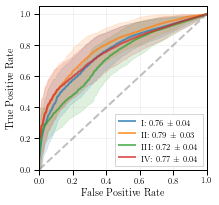

In [9]:
plot_superimposed_roc_curves([a,b],'mjff_attempt_' + str(which_attempt) +'_sentence_level')

## MJFF [spanish: sentence level]

In [10]:
from haberrspd.preprocess import create_proper_spanish_letters

In [11]:
# Load data
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'SpanishData-Nov_28_2019.csv', header=0)
df_meta = pd.read_csv(data_root / 'MJFF' / 'raw' / 'SpanishDiagnosisAndMedicationInfo.csv', header=0)

In [12]:
# 'correct' Spanish characters
df = create_proper_spanish_letters(df)

In [13]:
# No changes have been made
df_baselines_raw = calculate_iki_and_ed_baseline(df=df,
                                                 df_meta=df_meta,
                                                 which_dataset='mjff_spanish',
                                                 drop_shift=False,
                                                 invokation_type=-1)
# Error corrections have been made
df_baselines_edited = calculate_iki_and_ed_baseline(df=df,
                                                    df_meta=df_meta,
                                                    which_dataset='mjff_spanish',
                                                    drop_shift=False,
                                                    invokation_type=1)

MJFF
MJFF


In [14]:
a = calculate_all_baseline_ROC_curves(df_baselines_raw,n_reruns=100)
b = calculate_all_baseline_ROC_curves(df_baselines_edited, n_reruns=100)

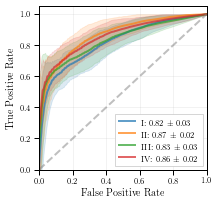

In [15]:
plot_superimposed_roc_curves([a,b],'mjff_spanish_sentence_level')

## MRC [sentence level]

In [29]:
df = pd.read_pickle(data_root / 'MRC' / 'processed_mrc_dataset.pkl')

In [73]:
df.drop(df.index[(df.type == "keyup")], inplace=True)
# Reset index so that we can sort it properly in the next step
df.reset_index(drop=True, inplace=True)
# In-place dropping of these rows
df.drop(df.index[(df.key == "β")], inplace=True)
# Reset index so that we can sort it properly in the next step
df.reset_index(drop=True, inplace=True)

Cases:

1. Controls vs. unmedicated patients i.e. `df.loc[(df.medication == 0)]`
2. Controls vs. medicated patients i.e. `df[(df.diagnosis == 1) & (df.medication == 1)] U df[(df.diagnosis == 0)]`

### Drop all shift keys

In [74]:
A = calculate_iki_and_ed_baseline(df,which_dataset='mrc',drop_shift=True,invokation_type=1) # Error corrections have been made

MRC


In [75]:
A

,Patient_ID,Sentence_ID,Diagnosis,Medication,Mean_IKI,Var_IKI,Edit_Distance
0,1010,1,0,0,332.229144,60706.718601,10
1,1011,1,0,0,381.347358,130976.142023,10
2,1012,1,0,0,218.803869,42762.431961,6
3,1014,1,0,0,233.846712,20228.298360,4
4,1013,1,0,0,444.516372,85486.891955,4
...,...,...,...,...,...,...,...
3285,139,15,1,1,342.889662,67945.630172,7
3286,140,15,1,1,249.825719,19361.797534,2
3287,141,15,1,1,215.101469,20457.775984,9
3288,142,15,1,1,338.401054,33764.109053,6


In [76]:
A.to_csv(data_root / "processed_MRC_all_mean_IKI_and_ED.csv", index=None)

In [ ]:
df_baselines_raw = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                 which_dataset='mrc',
                                                 drop_shift=True, 
                                                 invokation_type=-1) # No changes have been made
df = pd.read_pickle(data_root / 'MRC' / 'processed_mrc_dataset.pkl')
df_baselines_edited = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                    which_dataset='mrc',
                                                    drop_shift=True, 
                                                    invokation_type=1) # Error corrections have been made

---

In [29]:
df = pd.read_pickle(data_root / 'MRC' / 'processed_mrc_dataset.pkl')
# 2 from above list
new1 = pd.concat([df[(df.diagnosis == 1) & (df.medication == 1)],df[df.diagnosis == 0]],
                ignore_index=True)
new2 = new1.copy(deep=True)

In [30]:
df_baselines_raw = calculate_iki_and_ed_baseline(new1,
                                                 which_dataset='mrc',
                                                 drop_shift=True, 
                                                 invokation_type=-1) # No changes have been made
df_baselines_edited = calculate_iki_and_ed_baseline(new2,
                                                    which_dataset='mrc',
                                                    drop_shift=True, 
                                                    invokation_type=1) # Error corrections have been made

MRC
MRC


In [31]:
out1 = calculate_all_baseline_ROC_curves(df_baselines_raw,n_reruns=100)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited,n_reruns=100)

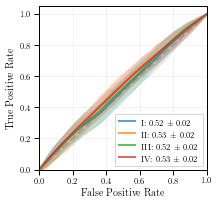

In [32]:
# For reasons unknown we can only run this once...
plot_superimposed_roc_curves([out1,out2],'mrc_with_dropped_shift_keys_medicated_patients_sentence_level')

### Shift keys are kept

In [18]:
# df.loc[(df.medication == 0)] use this to mimic MJFF dataset between controls and unmedicated-PD
df_baselines_raw = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                 which_dataset='mrc',
                                                 drop_shift=False, 
                                                 invokation_type=-1) # No changes have been made
df = pd.read_pickle(data_root / 'MRC' / 'processed_mrc_dataset.pkl')
df_baselines_edited = calculate_iki_and_ed_baseline(df.loc[(df.medication == 0)],
                                                    which_dataset='mrc',
                                                    drop_shift=False,
                                                    invokation_type=1) # Error corrections have been made

MRC


/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MRC


/home/neil/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
a = calculate_all_baseline_ROC_curves(df_baselines_raw, n_reruns=100)
b = calculate_all_baseline_ROC_curves(df_baselines_edited, n_reruns=100)

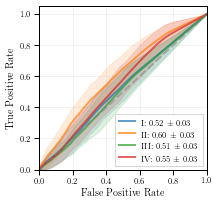

In [20]:
# mrc_shift_keys_kept_sentence_level
plot_superimposed_roc_curves([a,b],'mrc_with_shift_keys_sentence_level')

### MJFF [subject level]

In [ ]:
df_baselines_raw.head()

In [ ]:
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j,test_different_splits_for_classification(outs[j]))

### MRC [subject level]

In [21]:
part = convert_df_to_subject_level(df_baselines_raw)
outs = get_X_and_y_from_df(part)

In [23]:
# We use the version with shift keys kept
for i in [df_baselines_raw, df_baselines_edited]:
    outs = get_X_and_y_from_df(convert_df_to_subject_level(i))
    for j in ['I','II']:
        print(j, test_different_splits_for_classification(outs[j]))

I (0.787, 0.067)
II (0.952, 0.022)
I (0.797, 0.053)
II (0.981, 0.015)



I (0.791, 0.047)
II (0.947, 0.027)
I (0.789, 0.062)
II (0.976, 0.016)

---

## CNN results

In [18]:
rocs = defaultdict(list)
labels = ['C', 'C+T','C+T+S']
dataset='mrc'
attempt=2
language='english'
space = ['char','char_time','char_time_space']
# space = ['char_time_space']
for i, c in enumerate(space):
    lion_king = PostprocessTalos(dataset=dataset, language=language,which_information=c, attempt=attempt)
    rocs[labels[i]] = lion_king.get_fpr_and_tpr()

Load model from: ../results/MRC/char/english_mrc_attempt_2_talos_best_model_2019-12-08_20-59-20.zip
Load test data from: mrc/char/EnglishData-preprocessed_attempt_2.csv
Load model from: ../results/MRC/char_time/english_mrc_attempt_2_talos_best_model_2019-12-09_08-27-28.zip
Load test data from: mrc/char_time/EnglishData-preprocessed_attempt_2.csv
Load model from: ../results/MRC/char_time_space/english_mrc_attempt_2_talos_best_model_2019-12-09_19-30-14.zip
Load test data from: mrc/char_time_space/EnglishData-preprocessed_attempt_2.csv


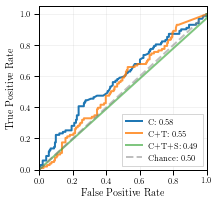

In [20]:
plot_superimposed_roc_curves(rocs,with_confidence_bounds=False,filename="{}_{}_{}".format(dataset,attempt,language))

--- 

# Old results from summer 2019

### Modelling CHARACTERS ('char') only

This commences the CNN approach to the task.

In [24]:
char = {100 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-03-33.csv', delimiter=','), 
        200 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-37-21.csv', delimiter=','), 
        500 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_17-46-29.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



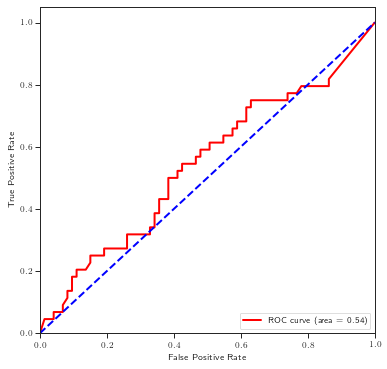

Number of hyperparameter permutations considered: 200



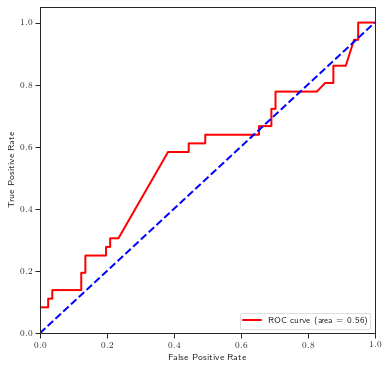

Number of hyperparameter permutations considered: 500



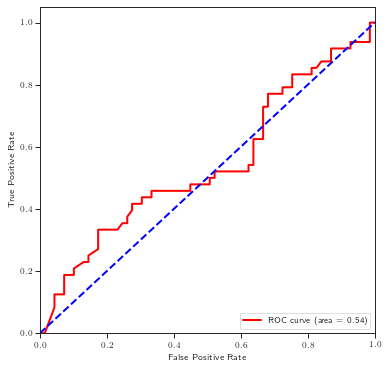

In [25]:
for key in char.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char[key][:,0].astype(np.int64), char[key][:,1])

In [ ]:
plot_roc_curve_simple(char[200][:,0].astype(np.int64), char[200][:,1],'mjff_char_only')

# CHARACTERS and TIME

In [26]:
char_time = {100 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_21-25-18.csv', delimiter=','), 
 200 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_15-00-06.csv', delimiter=','), 
 500 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_12-24-09.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



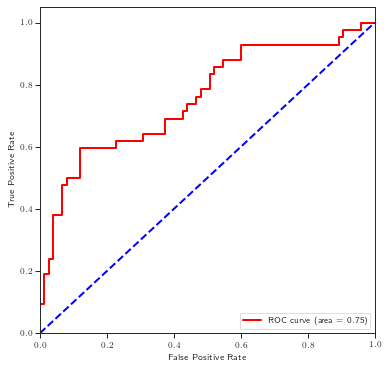

Number of hyperparameter permutations considered: 200



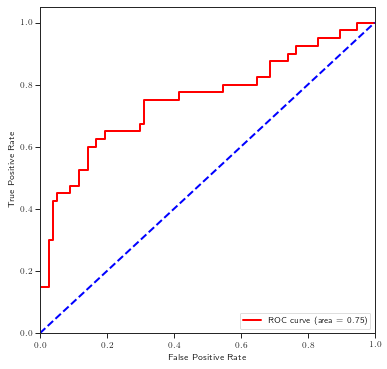

Number of hyperparameter permutations considered: 500



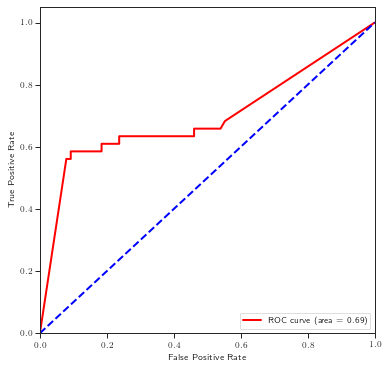

In [27]:
for key in char_time.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time[key][:,0].astype(np.int64), char_time[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time[200][:,0].astype(np.int64), char_time[200][:,1],'mjff_char_time')

# CHARACTERS and TIME and Space

In [28]:
char_time_space = {100 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_15-46-27.csv', delimiter=','), 
                   500 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_21-34-27.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



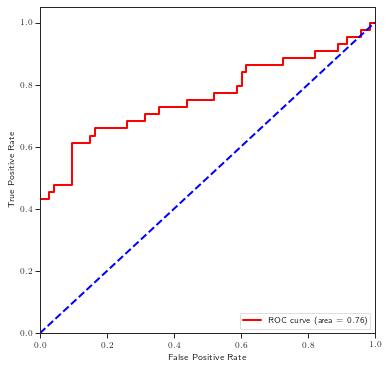

Number of hyperparameter permutations considered: 500



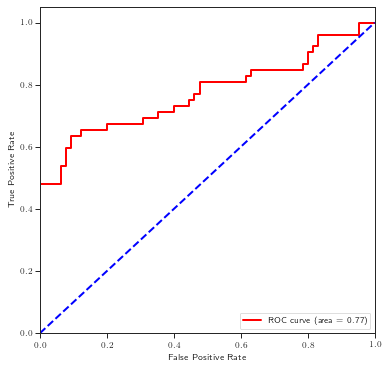

In [29]:
for key in char_time_space.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time_space[key][:,0].astype(np.int64), char_time_space[key][:,1])

In [ ]:
plot_roc_curve_simple(char_time_space[500][:,0].astype(np.int64), char_time_space[500][:,1],'mjff_char_time_space')

In [ ]:
# Check the details of the best model for one of the optimisations
df = pd.read_csv("../results/char_time_space/073019144454.csv")

In [ ]:
# Sort by validation accuracy
df.sort_values(by=['val_acc'],ascending=False).head(10)

In [ ]:
# Detailed look at the "winning model"
df.iloc[387,:]